In [6]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123456789)

(array([ 4.,  0.,  2.,  6.,  9., 15.,  9., 10., 12.,  9.,  8.,  4.,  4.,
         0.,  4.,  3.,  0.,  0.,  0.,  1.]),
 array([1.11314892, 1.37185377, 1.63055863, 1.88926348, 2.14796834,
        2.4066732 , 2.66537805, 2.92408291, 3.18278776, 3.44149262,
        3.70019748, 3.95890233, 4.21760719, 4.47631204, 4.7350169 ,
        4.99372176, 5.25242661, 5.51113147, 5.76983632, 6.02854118,
        6.28724603]),
 <BarContainer object of 20 artists>)

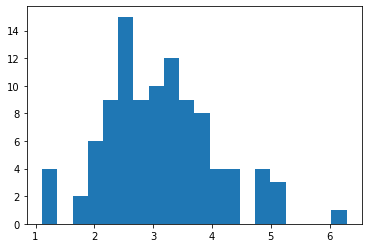

In [7]:
x = np.random.normal(loc=3,scale=1,size=100)
plt.hist(x, bins=20)

(array([ 3.,  1.,  6.,  5.,  5.,  5.,  6.,  9., 11., 12.,  6., 10.,  6.,
         7.,  2.,  4.,  1.,  0.,  0.,  1.]),
 array([0.79488547, 0.8162744 , 0.83766333, 0.85905226, 0.88044119,
        0.90183012, 0.92321905, 0.94460798, 0.96599691, 0.98738583,
        1.00877476, 1.03016369, 1.05155262, 1.07294155, 1.09433048,
        1.11571941, 1.13710834, 1.15849726, 1.17988619, 1.20127512,
        1.22266405]),
 <BarContainer object of 20 artists>)

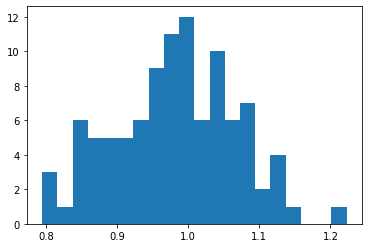

In [8]:
y = np.random.normal(loc=1,scale=0.1,size=100)
plt.hist(y, bins=20)

## Problem with R-squared comparisons between models with(out) an intercept

In [24]:
z = x + 2*y + np.random.normal(0,2,100)
X = np.vstack([x,y]).transpose()
X.shape

(100, 2)

The model here `z = x + 2y` doesn't have an intercept when (x,y) = 0, z = 0. So it should be better to fit it without an intercept

In [34]:
nointercept_model = sm.OLS(z, X).fit()
Xc= sm.add_constant(X)  #allows nonzero intercept
intercept_model = sm.OLS(z, Xc).fit()
print("R-squared with intercept =", intercept_model.rsquared )
print("R-squared without intercept =", nointercept_model.rsquared )

fit with intercept = 0.17862466754810813
fit without intercept = 0.874643036379007


The difference is massive! But that seems suspicious...

In [35]:
print( intercept_model.summary() )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     10.55
Date:                Mon, 21 Aug 2023   Prob (F-statistic):           7.17e-05
Time:                        07:54:23   Log-Likelihood:                -210.73
No. Observations:                 100   AIC:                             427.5
Df Residuals:                      97   BIC:                             435.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0172      2.394     -0.007      0.9

The intercept term is statistically equivalent to zero. The best fit value is quite small, so the intercept has barely any influence on the predictions. How can the R-squareds be so different?

Check out: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.rsquared.html#statsmodels.regression.linear_model.RegressionResults.rsquared

```
This is defined here as 1 - ssr/centered_tss if the constant is included in the model and 1 - ssr/uncentered_tss if the constant is omitted.
```
TSS means Total Sum of Squares

The centred_tss is
sum (yi - yav)**2

The uncentered_tss is (I assume)
sum (yi)**2

The second thing will be much bigger, since the output variables have a non-zero mean. This much bigger thing will divide the residual sum of squares and make it smaller, giving R squared much closer to 1


In [36]:
print("SSR with intercept =", intercept_model.ssr )
print("SSR without intercept =", nointercept_model.ssr )

SSR with intercept = 396.15194648356356
SSR without intercept = 396.1521568856103


The sum of squared residuals `sum (yi - predi)**2` can be compared between models and makes much more sense

## An alternative, out of sample testing

Comparing the SSR is not ideal. Among other things, the number depends on the number of absolute values of the output. So if we change its units it changes. The noce thing about Rsquared is that **good==1** is very intuitive. Could compare AIC and BIC, but same issue with interpretability.

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=12345)

In [41]:
nointercept_model = sm.OLS(z_train, X_train).fit()
Xc_train= sm.add_constant(X_train)  #allows nonzero intercept
intercept_model = sm.OLS(z_train, Xc_train).fit()

In [44]:
print(intercept_model.summary())
print(nointercept_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     10.66
Date:                Mon, 21 Aug 2023   Prob (F-statistic):           8.16e-05
Time:                        08:33:58   Log-Likelihood:                -167.94
No. Observations:                  80   AIC:                             341.9
Df Residuals:                      77   BIC:                             349.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0639      2.541      0.419      0.6

Note: the nointercept model is way better, as it should be, because it models the data using the right function! To compare the models with something like R-squared we can follow https://stats.stackexchange.com/questions/228540/how-to-calculate-out-of-sample-r-squared, see also https://arxiv.org/pdf/2302.05131.pdf

We have some baseline for MSE which we compare to out of sample (OOS) predictions
R_OSS = 1 - MSE_model / MSE_baseline


In [79]:
zbar = np.mean(z)
n_test = z_test.shape[0]
TSS = (np.sum( (z_test - zbar)**2 )/(n_test-1))*( (n_test + 1)/n_test )
TSS #this is Variance of the test set around the sample average times some scaling factor that probably doesn't matter


nointercept_pred = nointercept_model.predict(X_test)
Xc_test= sm.add_constant(X_test)  #allows nonzero intercept
intercept_pred = intercept_model.predict(Xc_test)

def MSE_OOS(pred):
    return np.sum( (z_test - pred)**2 )/n_test

print( "R_OSS(intercept) =", 1 - MSE_OOS(intercept_pred)/TSS )
print( "R_OSS(no_intercept) =", 1 - MSE_OOS(nointercept_pred)/TSS )

R_OSS(intercept) = 0.04886037975215063
R_OSS(no_intercept) = 0.06731354353233754


This means 
1. the no intercept model is a bit better than the intercept one.  
2. The model, just barely, outperforms the benchmark model (predicting outputs based on the average value)

Let's do the same analysis with less noisy data:

In [108]:
##everythign in one cell!
##make up some data
z = x + 2*y + np.random.normal(0,0.3,100)
X = np.vstack([x,y]).transpose()

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=12345)

nointercept_model = sm.OLS(z_train, X_train).fit()
Xc_train= sm.add_constant(X_train)  #allows nonzero intercept
intercept_model = sm.OLS(z_train, Xc_train).fit()

zbar = np.mean(z)
n_test = z_test.shape[0]
TSS = (np.sum( (z_test - zbar)**2 )/(n_test-1))*( (n_test + 1)/n_test )


nointercept_pred = nointercept_model.predict(X_test)
Xc_test= sm.add_constant(X_test)  #allows nonzero intercept
intercept_pred = intercept_model.predict(Xc_test)

def MSE_OOS(pred):
    return np.sum( (z_test - pred)**2 )/n_test

print(intercept_model.summary())
print("R-squared with intercept =", intercept_model.rsquared )
print("R-squared without intercept =", nointercept_model.rsquared )
print( "R_OSS(intercept) =", 1 - MSE_OOS(intercept_pred)/TSS )
print( "R_OSS(no_intercept) =", 1 - MSE_OOS(nointercept_pred)/TSS )

(80, 2)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     411.6
Date:                Mon, 21 Aug 2023   Prob (F-statistic):           7.74e-42
Time:                        09:34:19   Log-Likelihood:                -20.792
No. Observations:                  80   AIC:                             47.58
Df Residuals:                      77   BIC:                             54.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9352      0.404      2.316 

Note that these models do a **really** good job fitting the data. The R_OSS should be interpreted as the proportion of the null model's error/variance explained by the fitted model. In this case the null model is z_pred = mean(z). 

Rather than just 1 train test split, a K-fold cross validation would be more reliable.

In [110]:
z = x + 2*y + np.random.normal(0,0.3,100)
X = np.vstack([x,y]).transpose()


from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits)

Ross_intercept = 0
Ross_nointercept = 0
for i, (train, test) in enumerate(kf.split(X)):

    X_train, X_test = X[train], X[test]
    z_train, z_test = z[train], z[test]
    
    nointercept_model = sm.OLS(z_train, X_train).fit()
    Xc_train= sm.add_constant(X_train)  #allows nonzero intercept
    intercept_model = sm.OLS(z_train, Xc_train).fit()

    zbar = np.mean(z)
    n_test = z_test.shape[0]
    TSS = (np.sum( (z_test - zbar)**2 )/(n_test-1))*( (n_test + 1)/n_test )


    nointercept_pred = nointercept_model.predict(X_test)
    Xc_test= sm.add_constant(X_test)  #allows nonzero intercept
    intercept_pred = intercept_model.predict(Xc_test)

    def MSE_OOS(pred):
        return np.sum( (z_test - pred)**2 )/n_test

    Ross_intercept += ( 1 - MSE_OOS(intercept_pred)/TSS )
    Ross_nointercept += (1 - MSE_OOS(nointercept_pred)/TSS )

Ross_intercept /= n_splits
Ross_nointercept /= n_splits
print( "{}-fold CV R_OSS(intercept) =".format(n_splits), Ross_intercept)
print( "{}-fold CV R_OSS(nointercept) =".format(n_splits), Ross_nointercept)


5-fold CV R_OSS(intercept) = 0.9333484081555978
5-fold CV R_OSS(nointercept) = 0.9321524642427595
